<font size='5'>**Learning with Noisy Labels for Building Extraction on the Massachusetts Dataset**</font>

* In this notebook, we will first show the memorization effects of deep learning models trained with noisy labels, and then try three tricks (Self-ensembling, Bootstrapping, Sample correction) for training a segmentation model (U-Net) with omission noisy labels to extract buildings on the Massachusetts Dataset

* [Memorization effects](https://arxiv.org/abs/1706.05394) refers to a two-stage training with noisy labels. More precisely, in the first early-learning stage, model performance is continuously improved by dominant learning from most of the accurately labeled samples, while in the later memorization stage, model performance begins to be degraded for overfitting to label noise information. 

* [Massachusetts Buildings Dataset](https://www.cs.toronto.edu/~vmnih/data/) consists of 151 aerial images of the Boston area, with each of the images being 1500 × 1500 pixels for an area of 2.25 square kilometers. The datasets make use of imagery released by the state of Massachusetts. All imagery is rescaled to a resolution of 1 pixel per square meter. The target maps for the dataset were generated using data from the OpenStreetMap project. The large amount of high quality building footprint data was possible to collect from OpenStreetMap because the City of Boston contributed building footprints for the entire city to the OpenStreetMap project. Here we are using a tiny subset of 100 training patches and 50 test patches which are both of a size of 256$\times$256, and can be downloaed via [here](https://raw.githubusercontent.com/wangyi111/waw2023_weakly-supervised-learning/main/WAW_NS.zip).

* [Self-ensembling](https://proceedings.neurips.cc/paper/2017/hash/68053af2923e00204c3ca7c6a3150cf7-Abstract.html) also known as mean teacher is a method that averages model weights instead of label predictions. It was originally developed for semi-supervised learning, yet also shows effectiveness in combating label noise to some extent. 

* [Bootstrapping](https://arxiv.org/abs/1412.6596) combines original noisy labels and model predictions as soft reference data for loss calculation, which is an easy-to-implement regularization trick, such as the application to [road extraction with OpenStreetMap labels](https://elib.dlr.de/136343/1/Henry_et_al_Aerial_Road_Segmentation_Topological_Label_Noise.pdf).

* Pixel-wsie sample correction borrows the idea of the pseudo label strategy from the semi-supervsied domain. It iteratively updates reference labels with the model's predictions of a high confidence or low uncertainty. Here we show a simple example with the [class-wise adaptive threshold setting](https://ieeexplore.ieee.org/document/9397290).

# Preparation

## import packages

In [1]:
from os import listdir, makedirs
from os.path import join, exists

import cv2
import copy
import shutil
import random
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split

from scipy.signal import savgol_filter
import matplotlib.pyplot as plt

import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

## load data

* download and extract the dataset

In [2]:
!wget https://raw.githubusercontent.com/wangyi111/waw2023_weakly-supervised-learning/main/WAW_NS.zip
!unzip -qq WAW_NS.zip

* Dataset definition

In [3]:
class BuildingDataset(Dataset):
    def __init__(self, data_path, noise_dir_name='ns_seg', split='train', 
                 aug=True, origin_ns_dir=None):
        # data paths
        self.data_path = join(data_path, split, 'data')
        self.gt_path = join(data_path, split, 'seg')
        
        if exists(noise_dir_name):
            self.ns_path = noise_dir_name
        else:
            self.ns_path = join(data_path, split, noise_dir_name)
        
        if origin_ns_dir is not None:
            self.ons_path = join(data_path, split, origin_ns_dir)
        else:
            self.ons_path = None
        self.split = split
        self.aug = aug
        
        # transforms
        self.transform = transforms.Compose([transforms.ToTensor()])
        
        # paths for each sample
        self.imgs = []
        self.gts = []
        self.ns_labels = []
        
        # get img and label paths
        self.fnames = listdir(self.data_path)
        
        # number of samples in total
        self.length = len(self.fnames)
    
    def __len__(self):
        return self.length
    
    def __getitem__(self, index):
        fname = self.fnames[index]
        ipath = join(self.data_path, fname)
        gpath = join(self.gt_path, fname)
        npath = join(self.ns_path, fname)
        if self.ons_path is not None:
            onpath = join(self.ons_path, fname)
        
        # load data
        img = cv2.imread(ipath)/255.0
        gt = cv2.imread(gpath,0).astype(float)
        ns = cv2.imread(npath,0).astype(float)
        if self.ons_path is not None:
            ons = cv2.imread(onpath,0).astype(float)

        # transforms
        if self.split == 'train' and self.aug:
            # random flip
            if random.random() > 0.5:
                fcode = random.choice([-1,0,1])
                img = cv2.flip(img,fcode)
                gt = cv2.flip(gt,fcode)
                ns = cv2.flip(ns,fcode)
                if self.ons_path is not None:
                    ons = cv2.flip(ons,fcode)
        # to tensor
        img = self.transform(img)                
        gt = self.transform(gt)
        ns = self.transform(ns)
        if self.ons_path is not None:
            ons = self.transform(ons)
         
        return_dict = {'img': img.float(), 'gt': gt.long(), 'ns': ns.long(), 'fname':fname}
        if self.ons_path is not None: return_dict['ons'] = ons.long()
        
        return return_dict

* load data

In [4]:
fpd = 'WAW_NS' # 'subset'
batch_size = 5
test_batch_size = 50
# create datasets
train_set = BuildingDataset(fpd, split='train', noise_dir_name='ns_seg')
test_set = BuildingDataset(fpd, split='test', noise_dir_name='ns_seg')
print(f'total number of training/test samples: {len(train_set)}/{len(test_set)}')

# create data loaders
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=test_batch_size, shuffle=False)
print(f'training batch size: {batch_size}, number of training batches: {int(len(train_set)/batch_size)}')

total number of training/test samples: 100/50
training batch size: 5, number of training batches: 20


* image triple examples

Text(0.5, 1.0, 'Noisy labels')

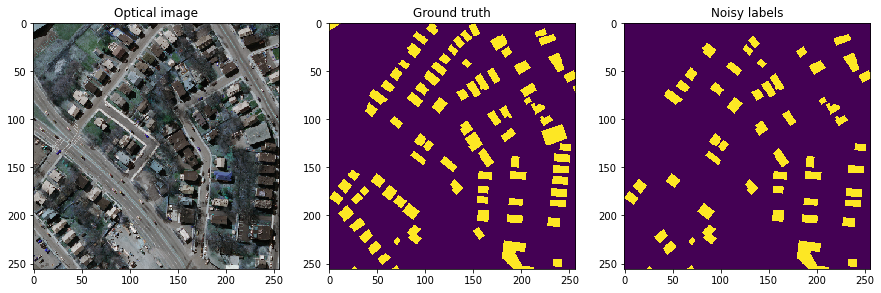

In [5]:
show_id = 1
img_chunk = train_set[show_id]
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,3,1)
ax1.imshow(img_chunk['img'].permute(1,2,0).numpy(), interpolation='none')
ax1.set_title('Optical image')
ax2 = fig.add_subplot(1,3,2)
ax2.imshow(img_chunk['gt'].squeeze(), interpolation='none')
ax2.set_title('Ground truth')
ax3 = fig.add_subplot(1,3,3)
ax3.imshow(img_chunk['ns'].squeeze(), interpolation='none')
ax3.set_title('Noisy labels')

## model construction functions

In [6]:
def get_student_model():
    net = smp.Unet(encoder_name='resnet18',        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
                   encoder_weights=None,           # use `imagenet` pre-trained weights for encoder initialization
                   in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
                   classes=1,                      # model output channels (number of classes in your dataset)
                   )
    return net 

# mean teacher model
def get_teacher_model(net, device):
    # Network definition
    net_ema = copy.deepcopy(net)

    # detach params
    for param in net_ema.parameters():
        param.detach_()

    # send to device
    net_ema.to(device=device)
    
    return net_ema

def update_teacher_model(net, net_ema, alpha=0.999):
    for ema_param, param in zip(net_ema.parameters(), net.parameters()):
        ema_param.data.mul_(alpha).add_(param.data, alpha=1 - alpha)
    return

## loss functions

In [7]:
LBCE = nn.BCEWithLogitsLoss()
LDICE = DiceLoss(mode='binary', from_logits=True)

def calculate_loss(pred_logits, true_masks):
    # calculate loss
    loss_cc = LBCE(pred_logits, true_masks)
    loss_cd = LDICE(pred_logits, true_masks)
    loss = loss_cc + loss_cd
    return loss

## test functions

In [8]:
def calculate_iou(gt, pred_logits): 
    eps=1e-8
    pred_masks = (torch.sigmoid(pred_logits) > 0.5).float()
    n_sam = np.shape(gt)[0]
    
    tmp = gt-pred_masks
    tp = ((tmp==0)*(gt==1)).sum(axis=(1,2))
    tn = ((tmp==0)*(gt==0)).sum(axis=(1,2))
    fp = (tmp==-1).sum(axis=(1,2))
    fn = (tmp==1).sum(axis=(1,2))

    iou_all = tp/(tp+fp+fn+eps)
    iou = iou_all.mean()
    return iou

def show_figures(images, gt_masks, ns_masks, pred_masks, tag):
    bind = 2
    fig = plt.figure(figsize=(5,20))
    ax1 = fig.add_subplot(141)
    ax1.imshow(images.cpu()[bind].numpy().transpose(1,2,0))
    ax1.set_title(tag, fontsize=6)
    ax1.axis('off')
    ax2 = fig.add_subplot(142)
    ax2.imshow(gt_masks.cpu()[bind].numpy(), interpolation='none')
    ax2.axis('off')
    ax2.set_title('gt', fontsize=6)
    ax3 = fig.add_subplot(143)
    ax3.imshow(ns_masks.cpu()[bind].numpy(), interpolation='none')
    ax3.axis('off')
    ax3.set_title('noisy labels', fontsize=6)
    ax4 = fig.add_subplot(144)
    ax4.imshow(pred_masks.cpu()[bind].numpy(), interpolation='none')
    ax4.axis('off')
    ax4.set_title('predict', fontsize=6)

def test_after_each_epoch(net, dataloader, show_fig=False):
    net.eval()
    ious = []
    for i,batch in enumerate(dataloader):
        images = batch['img'].to(device=device, dtype=torch.float32)
        gt_masks = torch.squeeze(batch['gt'],1).to(device=device, dtype=torch.float32)
        ns_masks = torch.squeeze(batch['ns'],1).to(device=device, dtype=torch.float32)
        pred_logits = net(images).squeeze(axis=1) 
        iou_ = calculate_iou(gt_masks, pred_logits)
        ious.append(iou_.item())
    net.train()
    
    if show_fig:
        pred_masks = (torch.sigmoid(pred_logits) > 0.5).float()
        show_figures(images, gt_masks, ns_masks, pred_masks, show_fig)
        
    return np.mean(ious)

def show_5figures(images, gt_masks, ns_masks, pred_masks, pred_masks_t, tag):
    bind = 2
    fig = plt.figure(figsize=(5,25))
    ax1 = fig.add_subplot(151)
    ax1.imshow(images.cpu()[bind].numpy().transpose(1,2,0))
    ax1.set_title(tag, fontsize=6)
    ax1.axis('off')
    ax2 = fig.add_subplot(152)
    ax2.imshow(gt_masks.cpu()[bind].numpy(), interpolation='none')
    ax2.axis('off')
    ax2.set_title('gt', fontsize=6)
    ax3 = fig.add_subplot(153)
    ax3.imshow(ns_masks.cpu()[bind].numpy(), interpolation='none')
    ax3.axis('off')
    ax3.set_title('noisy labels', fontsize=6)
    ax4 = fig.add_subplot(154)
    ax4.imshow(pred_masks.cpu()[bind].numpy(), interpolation='none')
    ax4.axis('off')
    ax4.set_title('student', fontsize=6)
    ax5 = fig.add_subplot(155)
    ax5.imshow(pred_masks_t.cpu()[bind].numpy(), interpolation='none')
    ax5.axis('off')
    ax5.set_title('teacher', fontsize=6)
    
def test_two_models_after_each_epoch(net, net_t, dataloader, show_fig=False):
    net.eval()
    ious, ious_t = [], []
    for i,batch in enumerate(dataloader):
        images = batch['img'].to(device=device, dtype=torch.float32)
        gt_masks = torch.squeeze(batch['gt'],1).to(device=device, dtype=torch.float32)
        ns_masks = torch.squeeze(batch['ns'],1).to(device=device, dtype=torch.float32)
        pred_logits = net(images).squeeze(axis=1) 
        pred_logits_t = net_t(images).squeeze(axis=1) 
        iou_ = calculate_iou(gt_masks, pred_logits)
        iou_t_ = calculate_iou(gt_masks, pred_logits_t)
        ious.append(iou_.item())
        ious_t.append(iou_t_.item())
    net.train()
    
    if show_fig:
        pred_masks = (torch.sigmoid(pred_logits) > 0.5).float()
        pred_masks_t = (torch.sigmoid(pred_logits_t) > 0.5).float()
        show_5figures(images, gt_masks, ns_masks, pred_masks, pred_masks_t, show_fig)
        
    return np.mean(ious), np.mean(ious_t)

# Memorization effects

## Hyperparameters settings

In [9]:
# hyperparameters
epochs = 200
show_intv = 40
# get models
net = get_student_model()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net.to(device)
print(f'We are working on {device}')
# # # # Optimizer # # # #
optimizer = optim.Adam(net.parameters(), lr=0.01, weight_decay=1e-8)
grad_scaler = torch.cuda.amp.GradScaler(enabled=True)

We are working on cuda


## Training

100%|██████████| 200/200 [03:44<00:00,  1.12s/it]


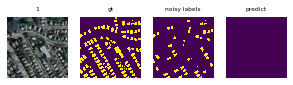

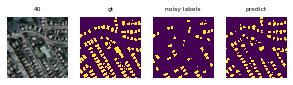

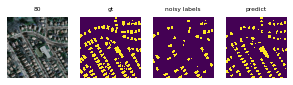

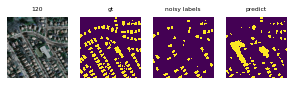

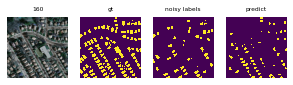

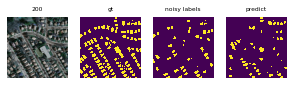

In [ ]:
train_acc_gt = []
train_acc_ns = []
test_acc = []
for epoch in tqdm(range(epochs)):
    train_acc_gt_ = []
    train_acc_ns_ = []
    # - TRAINING in each batch
    for batch in train_loader:
        # 1> load data
        images = batch['img'].to(device=device, dtype=torch.float32)        
        true_masks = torch.squeeze(batch['ns'],1).to(device=device, dtype=torch.float32)
        gt_masks = torch.squeeze(batch['gt'],1).to(device=device, dtype=torch.float32)

        # 2> forward
        with torch.cuda.amp.autocast(enabled=True):
            pred_logits = net(images).squeeze(axis=1) 
        loss = calculate_loss(pred_logits, true_masks)

        # 3> backforward - optimization
        optimizer.zero_grad(set_to_none=True)
        grad_scaler.scale(loss).backward()
        grad_scaler.step(optimizer)
        grad_scaler.update()

        # 4> training acc in each iteration
        ta_gt_ = calculate_iou(gt_masks, pred_logits)
        ta_ns_ = calculate_iou(true_masks, pred_logits)
        train_acc_gt_.append(ta_gt_.item())
        train_acc_ns_.append(ta_ns_.item())
    
    ta_gt = np.mean(train_acc_gt_)
    ta_ns = np.mean(train_acc_ns_)
    train_acc_gt.append(ta_gt)
    train_acc_ns.append(ta_ns)
    
    show_fig = epoch+1 if epoch==0 or ((epoch+1)%show_intv==0) else False
    tst_a = test_after_each_epoch(net, test_loader, show_fig)
    test_acc.append(tst_a.item())

## Accuracies

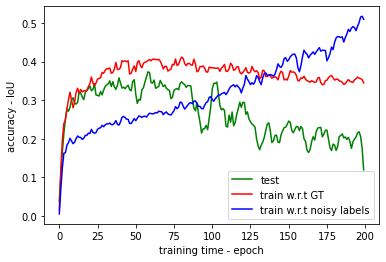

In [12]:
plt.figure()
x = np.arange(epochs)
plt.plot(x, savgol_filter(test_acc, window_length=11, polyorder=3), 'g-', label='test')
plt.plot(x, savgol_filter(train_acc_gt, window_length=5, polyorder=3),'r-', label='train w.r.t GT')
plt.plot(x, savgol_filter(train_acc_ns, window_length=5, polyorder=3), 'b-', label='train w.r.t noisy labels')
plt.xlabel('training time - epoch')
plt.ylabel('accuracy - IoU')
plt.legend()

# Self-ensembling

## Consistency loss function & weight ramp-up function

In [53]:
def mse_loss(input_logits, target_logits):
    """
    Takes softmax on both sides as inputs and returns MSE loss (mean)
    """
    assert input_logits.size() == target_logits.size()
    bs = input_logits.size()[0]
    input_softmax = torch.sigmoid(input_logits)
    target_softmax = torch.sigmoid(target_logits)
    return F.mse_loss(input_softmax, target_softmax, reduction='mean')

def sigmoid_rampup(current, rampup_length):
    """Exponential rampup from https://arxiv.org/abs/1610.02242"""
    if rampup_length == 0:
        return 1.0
    else:
        current = np.clip(current, 0.0, rampup_length)
        phase = 1.0 - current / rampup_length
        return float(np.exp(-5.0 * phase * phase))

## Hyperparameters setting

In [54]:
# hyperparameters
epochs = 200
show_intv = 40
# for consistency loss
ramp_up_len = 80
beta = 1
# get models
net = get_student_model()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net.to(device)
print(f'We are working on {device}')
net_t = get_teacher_model(net, device)
# # # # Optimizer # # # #
optimizer = optim.Adam(net.parameters(), lr=0.01, weight_decay=1e-8)
grad_scaler = torch.cuda.amp.GradScaler(enabled=True)

We are working on cuda


## Training

100%|██████████| 200/200 [04:14<00:00,  1.27s/it]


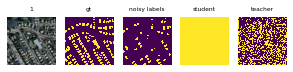

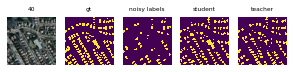

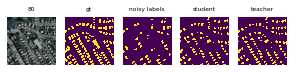

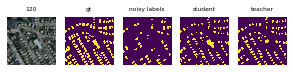

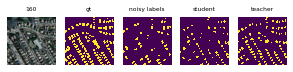

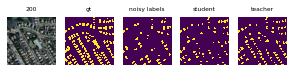

In [55]:
test_acc_t, test_acc_s = [], []
for epoch in tqdm(range(epochs)):
    # - TRAINING in each batch
    for batch in train_loader:
        # 1> load data
        images = batch['img'].to(device=device, dtype=torch.float32)        
        true_masks = torch.squeeze(batch['ns'],1).to(device=device, dtype=torch.float32)
        gt_masks = torch.squeeze(batch['gt'],1).to(device=device, dtype=torch.float32)

        # 2> forward
        with torch.cuda.amp.autocast(enabled=True):
            pred_logits = net(images).squeeze(axis=1) 
            pred_logits_t = net_t(images).squeeze(axis=1) 
        loss_seg = calculate_loss(pred_logits, true_masks)
        ################# self-ensemble consistency loss #################
        loss_con = mse_loss(pred_logits, pred_logits_t)
        consist_w = sigmoid_rampup(epoch, ramp_up_len)
        loss = loss_seg + beta*consist_w*loss_con

        # 3> backforward - optimization
        optimizer.zero_grad(set_to_none=True)
        grad_scaler.scale(loss).backward()
        grad_scaler.step(optimizer)
        grad_scaler.update()
        ################# update teacher model #################
        update_teacher_model(net, net_t)
    
    show_fig = epoch+1 if epoch==0 or (epoch+1)%show_intv==0 else False
    test_s, test_t = test_two_models_after_each_epoch(net, net_t, test_loader, show_fig)
    test_acc_s.append(test_s.item())
    test_acc_t.append(test_t.item())

## Accuracies

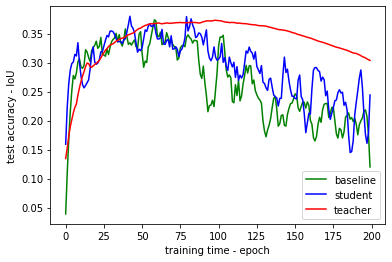

In [56]:
plt.figure()
x = np.arange(epochs)
plt.plot(x, savgol_filter(test_acc, window_length=11, polyorder=3), 'g-', label='baseline')
plt.plot(x, savgol_filter(test_acc_s, window_length=11, polyorder=3),'b-', label='student')
plt.plot(x, test_acc_t, 'r-', label='teacher')
plt.xlabel('training time - epoch')
plt.ylabel('test accuracy - IoU')
plt.legend()

# Bootstrapping

## Hyperparameters setting

In [42]:
# hyperparameters
epochs = 200
show_intv = 40
# for consistency loss
ramp_up_len = 50
beta = 0.3
pred_type = 'teacher'  # or 'student' or 'teacher'
combine_type = 'hard'  # or 'hard' or 'soft'
# get models
net = get_student_model()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net.to(device)
print(f'We are working on {device}')
net_t = get_teacher_model(net, device)
# # # # Optimizer # # # #
optimizer = optim.Adam(net.parameters(), lr=0.01, weight_decay=1e-8)
grad_scaler = torch.cuda.amp.GradScaler(enabled=True)

We are working on cuda


## Training

100%|██████████| 200/200 [04:15<00:00,  1.28s/it]


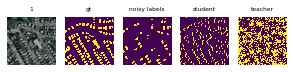

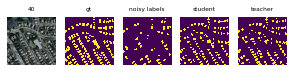

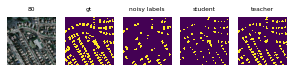

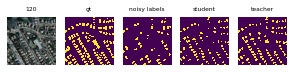

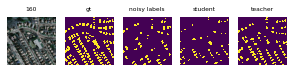

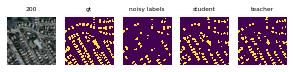

In [43]:
test_acc_bt, test_acc_bs = [], []
for epoch in tqdm(range(epochs)):
    # - TRAINING in each batch
    for batch in train_loader:
        # 1> load data
        images = batch['img'].to(device=device, dtype=torch.float32)        
        true_masks = torch.squeeze(batch['ns'],1).to(device=device, dtype=torch.float32)
        gt_masks = torch.squeeze(batch['gt'],1).to(device=device, dtype=torch.float32)

        # 2> forward
        with torch.cuda.amp.autocast(enabled=True):
            pred_logits = net(images).squeeze(axis=1) 
            pred_logits_t = net_t(images).squeeze(axis=1) 
        ################# bootstrapping #################
        # predicted labels
        if pred_type == 'student':
            pred_soft = torch.sigmoid(pred_logits)
        elif pred_type == 'teacher':
            pred_soft = torch.sigmoid(pred_logits_t)
        else:
            raise ValueError('pred_soft!=student or teacher!')
        pred_hard = (pred_soft>0.5).float()
        # beta - weight of original noisy labels
        beta = beta + (1-sigmoid_rampup(epoch, ramp_up_len))*(1-beta)
        # get reference masks
        if combine_type == 'hard':
            ref_masks = beta*true_masks+(1-beta)*pred_hard
        elif combine_type == 'soft':
            ref_masks = beta*true_masks+(1-beta)*pred_soft
        else:
            raise ValueError('combine_type!=hard or soft!')
        loss = calculate_loss(pred_logits, ref_masks)

        # 3> backforward - optimization
        optimizer.zero_grad(set_to_none=True)
        grad_scaler.scale(loss).backward()
        grad_scaler.step(optimizer)
        grad_scaler.update()
        ################# update teacher model #################
        update_teacher_model(net, net_t)
    
    show_fig = epoch+1 if epoch==0 or (epoch+1)%show_intv==0 else False
    test_s, test_t = test_two_models_after_each_epoch(net, net_t, test_loader, show_fig)
    test_acc_bs.append(test_s.item())
    test_acc_bt.append(test_t.item())

## Accuracies

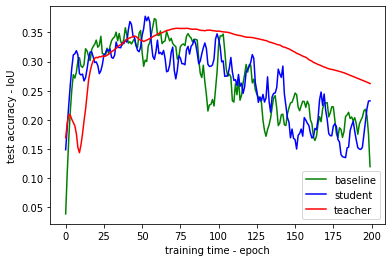

In [44]:
plt.figure()
x = np.arange(epochs)
plt.plot(x, savgol_filter(test_acc[:epochs], window_length=11, polyorder=3), 'g-', label='baseline')
plt.plot(x, savgol_filter(test_acc_bs, window_length=11, polyorder=3),'b-', label='student')
plt.plot(x, test_acc_bt, 'r-', label='teacher')
plt.xlabel('training time - epoch')
plt.ylabel('test accuracy - IoU')
plt.legend()

# Sample correction

## Pixel-wise sample correction function

In [13]:
def pixel_wise_correct(net, data_loader, device, sdir, ctype='confidence', K=0.6, 
                       adaptive_K=False, adaptive_type='all', eps=1e-8):
    net.eval()
    
    # check parameter settings
    assert ctype=='confidence' or ctype=='uncertainty', \
        'Invalid input for sample selection criterion type setting (expected: confidence or uncertainty)!'
    if adaptive_K:
        assert adaptive_type=='all' or adaptive_type=='class', \
            "Please choose adaptive thresholding setting method for confidence criterion (expected: all or class)!"
        
    # sample correction in a batch by batch fashion
    for bi, batch in enumerate(data_loader):
        # 1. load data
        images = batch['img'].to(device=device, dtype=torch.float32)   
        # mask_true = torch.squeeze(batch['gt'],1).to(device=device, dtype=torch.float32)          
        update_labels = torch.squeeze(batch['ns'],1).to(device=device, dtype=torch.float32)
        fnames = batch['fname']
        
        # 2. make predictions
        with torch.no_grad():
            pred_outs = net(images).squeeze(axis=1)
            pred_logits = torch.sigmoid(pred_outs)
            pred_masks = (pred_logits>0.5).float()
        
        # 3. sample correction
        if ctype == 'uncertainty':
            # 1> calculate uncertainties
            uncertainties = -pred_logits*torch.log(pred_logits)
            uncertainties += -(1-pred_logits)*torch.log(1-pred_logits)
            # 2> threshold setting
            if adaptive_K:
                # # set threshold based on all the samples
                if adaptive_type=='all':
                    thrs = uncertainties.mean(dim=(1,2),keepdim=True)
                    thrs[thrs<K] = K
                elif adaptive_type=='class':
                    thrs_1 = (uncertainties*pred_masks).sum(dim=(1,2),keepdim=True)/(pred_masks.sum(dim=(1,2),keepdim=True)+eps)
                    thrs_0 = (uncertainties*(1-pred_masks)).sum(dim=(1,2),keepdim=True)/((1-pred_masks).sum(dim=(1,2),keepdim=True)+eps)
                    thrs_1[thrs_1<K] = K
                    thrs_0[thrs_0<K] = K
                    thrs = thrs_1*pred_masks+thrs_0*(1-pred_masks)
            else:
                thrs = K
            # 3> correct sample labels whoes uncertainties are below threshold
            un_diff = uncertainties - thrs
            update_labels[un_diff<0] = pred_masks[un_diff<0]
        elif ctype == 'confidence':
            # 1> claculate confidence
            confs = pred_masks*pred_logits+(1-pred_masks)*(1-pred_logits)
            # 2> threshold setting
            if adaptive_K:
                # # set threshold based on all the samples
                if adaptive_type=='all':
                    thrs = confs.mean(dim=(1,2),keepdim=True)
                    thrs[thrs>K] = K
                # # set threshold in a class-wise fashion
                elif adaptive_type=='class':
                    thrs_1 = (confs*pred_masks).sum(dim=(1,2),keepdim=True)/(pred_masks.sum(dim=(1,2),keepdim=True)+eps)
                    thrs_0 = (confs*(1-pred_masks)).sum(dim=(1,2),keepdim=True)/((1-pred_masks).sum(dim=(1,2),keepdim=True)+eps)
                    thrs_1[thrs_1>K] = K
                    thrs_0[thrs_0>K] = K
                    thrs = thrs_1*pred_masks+thrs_0*(1-pred_masks)
            else:
                thrs = K
            # 3> correct sample labels whoes confidences are greater than threshold
            conf_diff = confs - thrs
            update_labels[conf_diff>0] = pred_masks[conf_diff>0]
        
        # 4. save corrected samples
        for fi, f in enumerate(fnames):
            fpath = join(sdir,f)
            new_mask = update_labels[fi].squeeze()
            if device!=torch.device('cpu'):
                new_mask = new_mask.cpu()
            new_mask = new_mask.numpy().astype(np.uint8)
            cv2.imwrite(fpath, new_mask)
    
    # reset model status to training
    net.train()
        
    return

## Data preparation
* Here we construction two training loaders, including one for training (with data augmentation) and another one for correction (without data augmentation)

In [133]:
# create the saving directory for corrected labels (initialize it with original noisy labels)
save_dir = join(fpd, 'train', 'corrected_labels')
if exists(save_dir): shutil.rmtree(save_dir)
shutil.copytree(join(fpd, 'train', 'ns_seg'), save_dir)
print(f'"{save_dir}" has been successfully created for storing corrected labels.')

# data loaders: 
# one for training    
train_set = BuildingDataset(fpd, split='train', noise_dir_name='corrected_labels')
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
# one for correction
train_set_c = BuildingDataset(fpd, split='train', noise_dir_name='corrected_labels', aug=False)
bs_c = len(train_set_c)
train_loader_c = DataLoader(train_set_c, batch_size=bs_c, shuffle=False)

"WAW_NS/train/corrected_labels" has been successfully created for storing corrected labels.


## Hyperparameters setting

In [138]:
# hyperparameters
epochs = 150
show_intv = 40
# for sample correction
pred_type = 'teacher'  # or 'teacher' or 'teacher'
correct_start_point = 80
# get models
net = get_student_model()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net.to(device)
# print(f'We are working on {device}')
net_t = get_teacher_model(net, device)
# # # # Optimizer # # # #
optimizer = optim.Adam(net.parameters(), lr=0.01, weight_decay=1e-8)
grad_scaler = torch.cuda.amp.GradScaler(enabled=True)
scheduler1 = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[correct_start_point], 
                                                  gamma=1)
scheduler2 = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer, 
                                                  schedulers=[scheduler1, scheduler2], 
                                                  milestones=[correct_start_point],
                                                  )

We are working on cuda


## Training

100%|██████████| 150/150 [03:35<00:00,  1.44s/it]


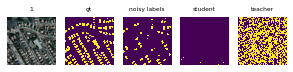

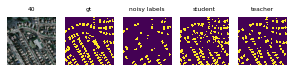

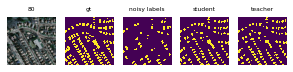

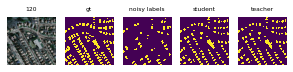

In [32]:
test_acc_sct, test_acc_scs = [], []
for epoch in tqdm(range(epochs)):
    ################# CORRECTION #################
    if epoch > correct_start_point:
        pixel_wise_correct(net_t if pred_type=='teacher' else net, 
                           train_loader_c, 
                           device, 
                           sdir=save_dir, 
                           ctype='confidence', K=0.9, 
                           adaptive_K=True, 
                           adaptive_type='class',
                          )
        
    # - TRAINING in each batch
    for batch in train_loader:
        # 1> load data
        images = batch['img'].to(device=device, dtype=torch.float32)        
        true_masks = torch.squeeze(batch['ns'],1).to(device=device, dtype=torch.float32)
        gt_masks = torch.squeeze(batch['gt'],1).to(device=device, dtype=torch.float32)

        # 2> forward
        with torch.cuda.amp.autocast(enabled=True):
            pred_logits = net(images).squeeze(axis=1) 
        loss = calculate_loss(pred_logits, true_masks)

        # 3> backforward - optimization
        optimizer.zero_grad(set_to_none=True)
        grad_scaler.scale(loss).backward()
        grad_scaler.step(optimizer)
        grad_scaler.update()
        ################# update teacher model #################
        update_teacher_model(net, net_t)
    
    show_fig = epoch+1 if epoch==0 or (epoch+1)%show_intv==0 else False
    test_s, test_t = test_two_models_after_each_epoch(net, net_t, test_loader, show_fig)
    test_acc_scs.append(test_s.item())
    test_acc_sct.append(test_t.item())
    scheduler.step()

## Accuracies

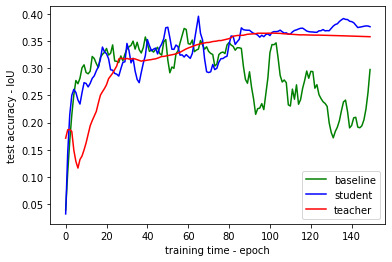

In [ ]:
plt.figure()
x = np.arange(epoch+1)
plt.plot(x, savgol_filter(test_acc[:epoch+1], window_length=11, polyorder=3), 'g-', label='baseline')
plt.plot(x, savgol_filter(test_acc_scs, window_length=11, polyorder=3),'b-', label='student')
plt.plot(x, test_acc_sct, 'r-', label='teacher')
plt.xlabel('training time - epoch')
plt.ylabel('test accuracy - IoU')
plt.legend()